<a href="https://colab.research.google.com/github/tahaofqirhamma/-GoalTracker-app-back/blob/main/SA_USING_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Import the necessary libraries**

In [1]:
import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


**Step 2: Load the dataset**

In [2]:
# Get the current working directory
current_folder = os.getcwd()

dataset = tf.keras.utils.get_file(
	fname ="aclImdb.tar.gz",
	origin ="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
	cache_dir= current_folder,
	extract = True)


84125825/84125825 [==============================] - 3s 0us/step


**check the dataset folder**

In [3]:
dataset_path = os.path.dirname(dataset)
# Check the dataset
os.listdir(dataset_path)


['aclImdb.tar.gz', 'aclImdb']

In [4]:
# Dataset directory
dataset_dir = os.path.join(dataset_path, 'aclImdb')

# Check the Dataset directory
os.listdir(dataset_dir)


['train', 'imdbEr.txt', 'test', 'imdb.vocab', 'README']

In [5]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)


['urls_neg.txt',
 'pos',
 'urls_unsup.txt',
 'unsup',
 'labeledBow.feat',
 'urls_pos.txt',
 'unsupBow.feat',
 'neg']

Read the files of the ‘Train’ directory files
**bold text**

In [6]:
for file in os.listdir(train_dir):
	file_path = os.path.join(train_dir, file)
	# Check if it's a file (not a directory)
	if os.path.isfile(file_path):
		with open(file_path, 'r', encoding='utf-8') as f:
			first_value = f.readline().strip()
			print(f"{file}: {first_value}")
	else:
		print(f"{file}: {file_path}")


urls_neg.txt: http://www.imdb.com/title/tt0064354/usercomments
pos: /content/datasets/aclImdb/train/pos
urls_unsup.txt: http://www.imdb.com/title/tt0018515/usercomments
unsup: /content/datasets/aclImdb/train/unsup
labeledBow.feat: 9 0:9 1:1 2:4 3:4 4:6 5:4 6:2 7:2 8:4 10:4 12:2 26:1 27:1 28:1 29:2 32:1 41:1 45:1 47:1 50:1 54:2 57:1 59:1 63:2 64:1 66:1 68:2 70:1 72:1 78:1 100:1 106:1 116:1 122:1 125:1 136:1 140:1 142:1 150:1 167:1 183:1 201:1 207:1 208:1 213:1 217:1 230:1 255:1 321:5 343:1 357:1 370:1 390:2 468:1 514:1 571:1 619:1 671:1 766:1 877:1 1057:1 1179:1 1192:1 1402:2 1416:1 1477:2 1940:1 1941:1 2096:1 2243:1 2285:1 2379:1 2934:1 2938:1 3520:1 3647:1 4938:1 5138:4 5715:1 5726:1 5731:1 5812:1 8319:1 8567:1 10480:1 14239:1 20604:1 22409:4 24551:1 47304:1
urls_pos.txt: http://www.imdb.com/title/tt0453418/usercomments
unsupBow.feat: 0 0:8 1:6 3:5 4:2 5:1 7:1 8:5 9:2 10:1 11:2 13:3 16:1 17:1 18:1 19:1 22:3 24:1 26:3 28:1 30:1 31:1 35:2 36:1 39:2 40:1 41:2 46:2 47:1 48:1 52:1 63:1 67:

Load the Movies reviews and convert them into the pandas’ data frame with their respective sentiment
Here 0 means Negative and 1 means Positive

In [7]:
def load_dataset(directory):
	data = {"sentence": [], "sentiment": []}
	for file_name in os.listdir(directory):
		print(file_name)
		if file_name == 'pos':
			positive_dir = os.path.join(directory, file_name)
			for text_file in os.listdir(positive_dir):
				text = os.path.join(positive_dir, text_file)
				with open(text, "r", encoding="utf-8") as f:
					data["sentence"].append(f.read())
					data["sentiment"].append(1)
		elif file_name == 'neg':
			negative_dir = os.path.join(directory, file_name)
			for text_file in os.listdir(negative_dir):
				text = os.path.join(negative_dir, text_file)
				with open(text, "r", encoding="utf-8") as f:
					data["sentence"].append(f.read())
					data["sentiment"].append(0)

	return pd.DataFrame.from_dict(data)


In [8]:
# Load the dataset from the train_dir
train_df = load_dataset(train_dir)
print(train_df.head())


urls_neg.txt
pos
urls_unsup.txt
unsup
labeledBow.feat
urls_pos.txt
unsupBow.feat
neg
                                            sentence  sentiment
0  I saw it at the Legacy Theater in the Joseph S...          1
1  This was a gem. Amazing acting from the leads ...          1
2  It was considered to be the "Swiss answer to t...          1
3  Yep, you read that right, kids. Michael Bay sh...          1
4  Film can be a looking glass to see the world i...          1


In [9]:
test_dir = os.path.join(dataset_dir,'test')

# Load the dataset from the train_dir
test_df = load_dataset(test_dir)
print(test_df.head())


urls_neg.txt
pos
labeledBow.feat
urls_pos.txt
neg
                                            sentence  sentiment
0  His music, especially what we hear of it here,...          1
1  This movie accurately portrays the struggle li...          1
2  If you think about it, it's nearly unbelievabl...          1
3  I caught this movie late night on TV, and was ...          1
4  A talented high school graduating senior with ...          1


In [10]:
sentiment_counts = train_df['sentiment'].value_counts()

fig =px.bar(x= {0:'Negative',1:'Positive'},
			y= sentiment_counts.values,
			color=sentiment_counts.index,
			color_discrete_sequence = px.colors.qualitative.Dark24,
			title='<b>Sentiments Counts')

fig.update_layout(title='Sentiments Counts',
				xaxis_title='Sentiment',
				yaxis_title='Counts',
				template='plotly_dark')

# Show the bar chart
fig.show()
pyo.plot(fig, filename = 'Sentiments Counts.html', auto_open = True)


'Sentiments Counts.html'

**Text Cleaning**

In [11]:
def text_cleaning(text):
	soup = BeautifulSoup(text, "html.parser")
	text = re.sub(r'\[[^]]*\]', '', soup.get_text())
	pattern = r"[^a-zA-Z0-9\s,']"
	text = re.sub(pattern, '', text)
	return text


In [12]:
# Train dataset
train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning).tolist()
# Test dataset
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning)


<ipython-input-11-2374454d2258>:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

<ipython-input-11-2374454d2258>:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



**Plot reviews on WordCLouds**

In [13]:
# Function to generate word cloud
def generate_wordcloud(text,Title):
	all_text = " ".join(text)
	wordcloud = WordCloud(width=800,
						height=400,
						stopwords=set(STOPWORDS),
						background_color='black').generate(all_text)
	plt.figure(figsize=(10, 5))
	plt.imshow(wordcloud, interpolation='bilinear')
	plt.axis("off")
	plt.title(Title)
	plt.show()


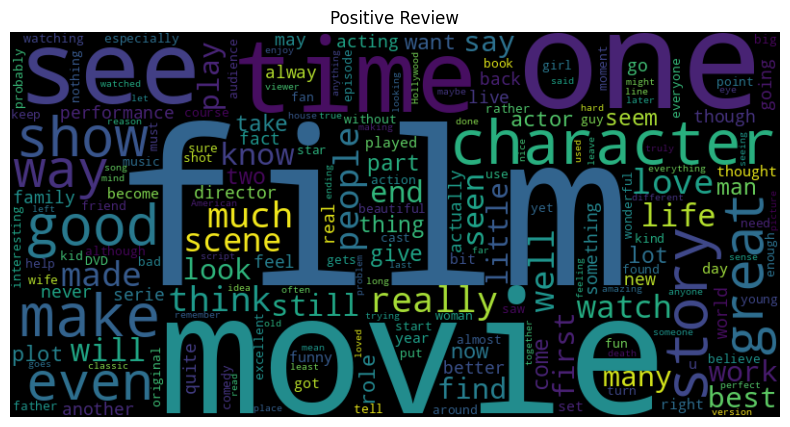

In [14]:
positive = train_df[train_df['sentiment']==1]['Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')


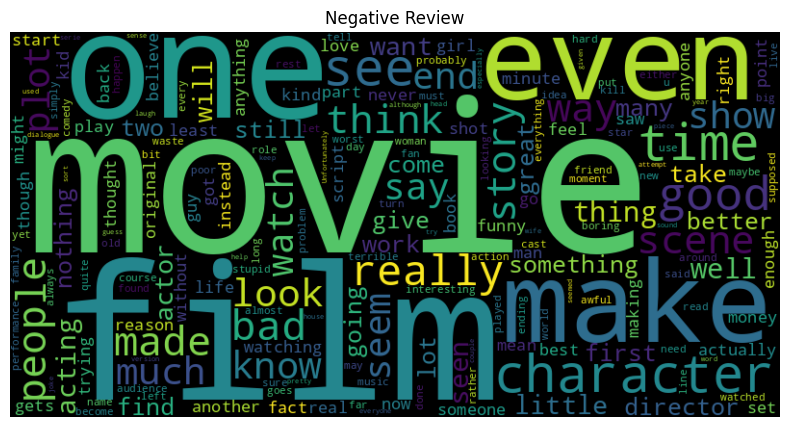

In [15]:
negative = train_df[train_df['sentiment']==0]['Cleaned_sentence'].tolist()
generate_wordcloud(negative,'Negative Review')


**Separate input text and target sentiment of both train and test**

In [16]:
# Training data
#Reviews = "[CLS] " +train_df['Cleaned_sentence'] + "[SEP]"
Reviews = train_df['Cleaned_sentence']
Target = train_df['sentiment']

# Test data
#test_reviews = "[CLS] " +test_df['Cleaned_sentence'] + "[SEP]"
test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']


**Split TEST data into test and validation**

In [17]:
x_val, x_test, y_val, y_test = train_test_split(test_reviews,
													test_targets,
													test_size=0.5,
													stratify = test_targets)


BERT tokenization is used to convert the raw text into numerical inputs that can be fed into the BERT model. It tokenized the text and performs some preprocessing to prepare the text for the model’s input format. Let’s understand some of the key features of the BERT tokenization model.


BERT tokenizer adds special tokens like [CLS], [SEP], and [MASK] to the sequence. These tokens have special meanings like :
[CLS] is used for classifications and to represent the entire input in the case of sentiment analysis,
[SEP] is used as a separator i.e. to mark the boundaries between different sentences or segments,
[MASK] is used for masking i.e. to hide some tokens from the model during pre-training.

In [18]:
#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Apply the BERT tokenization in training, testing and validation dataset**

In [19]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')


In [20]:
k = 0
print('Training Comments -->>',Reviews[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',Target[k])


Training Comments -->> I saw it at the Legacy Theater in the Joseph Smith Memorial Building in Salt Lake City this morning I'm going to assume that one's level of enjoyment during this movie will largely be based on one's level of acceptance of Joseph's storyHowever, that aside it was very well made, well acted, and had a nice score If you get to Salt Lake City, it is a must to see it in the Legacy Theater I have never been in a nicer theater as far as picture quality, sound quality and ambiance in my entire lifeI wonder if the Church would let me watch Batman Begins there Being that I'm LDS and regard Joseph as a prophet, I was touched in several places and was brought to tears quite a few timeswhich I presume is expected since they handed out tissues BEFORE the movie started Anyway, I'm told that this film is available in several LDS Visitor Centers around the globe, if you have 70 minutes check it out because whether you believe Joseph Smith or not, he tells a fascinating story

Inp

In [21]:
# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


In [23]:
# Step 5: Fine-tuning the model
history = model.fit(
	[X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
	Target,
	validation_data=(
	[X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
	batch_size=32,
	epochs=3
)


Epoch 1/3
782/782 [==============================] - 817s 987ms/step - loss: 0.3337 - accuracy: 0.8509 - val_loss: 0.2612 - val_accuracy: 0.8896
Epoch 2/3
782/782 [==============================] - 770s 984ms/step - loss: 0.2031 - accuracy: 0.9216 - val_loss: 0.2609 - val_accuracy: 0.8926
Epoch 3/3
782/782 [==============================] - 769s 983ms/step - loss: 0.1098 - accuracy: 0.9604 - val_loss: 0.3301 - val_accuracy: 0.8802


In [24]:
#Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
	y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')


391/391 [==============================] - 107s 275ms/step - loss: 0.3402 - accuracy: 0.8799
Test loss: 0.34021297097206116, Test accuracy: 0.8799200057983398


In [25]:
path = os.getcwd()

tokenizer.save_pretrained(path +'/Tokenizer')

# Save model
model.save_pretrained(path +'/Model')


In [26]:
# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer')

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model')


Some layers from the model checkpoint at /content/Model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [27]:
pred = bert_model.predict(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = {
	1: 'positive',
	0: 'Negative'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :', pred_labels[:10])
print('Actual Label :', Actual[:10])


391/391 [==============================] - 109s 272ms/step
Predicted Label : ['positive', 'positive', 'positive', 'Negative', 'Negative', 'positive', 'positive', 'positive', 'positive', 'Negative']
Actual Label : ['positive', 'Negative', 'positive', 'Negative', 'Negative', 'positive', 'positive', 'positive', 'positive', 'positive']


In [28]:
print("Classification Report: \n", classification_report(Actual, pred_labels))


Classification Report: 
               precision    recall  f1-score   support

    Negative       0.92      0.83      0.87      6250
    positive       0.85      0.93      0.89      6250

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500



In [29]:
def Get_sentiment(Review, Tokenizer=bert_tokenizer, Model=bert_model):
	# Convert Review to a list if it's not already a list
	if not isinstance(Review, list):
		Review = [Review]

	Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
																			padding=True,
																			truncation=True,
																			max_length=128,
																			return_tensors='tf').values()
	prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])

	# Use argmax along the appropriate axis to get the predicted labels
	pred_labels = tf.argmax(prediction.logits, axis=1)

	# Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
	pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
	return pred_labels


In [30]:
Review ='''*An absolute cinematic delight, [Film Title] captivates with its heartfelt storytelling and stunning visuals. The cast delivers exceptional performances, breathing life into richly layered characters that resonate deeply. The direction is masterful, blending emotional depth with moments of humor and charm. A poignant score and breathtaking cinematography elevate the experience to unforgettable heights. This film is a must-watch—a beautiful celebration of love, resilience, and the magic of cinema.*'''
Get_sentiment(Review)


1/1 [==============================] - 7s 7s/step


['positive']